# Diffusion Model Training on MNIST

This notebook implements a diffusion model using the DeepInverse library to train on MNIST digits. The model learns to denoise images by predicting the noise that was added during the forward diffusion process.

## Import Libraries and Setup

In [1]:
!pip install deepinv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.1/724.1 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import deepinv
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


## Configuration and Hyperparameters

In [3]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Training hyperparameters
batch_size = 32
image_size = 32
lr = 1e-4
epochs = 100

# Diffusion hyperparameters
beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

print(f"Batch size: {batch_size}")
print(f"Image size: {image_size}x{image_size}")
print(f"Learning rate: {lr}")
print(f"Epochs: {epochs}")
print(f"Timesteps: {timesteps}")

Using device: cuda
Batch size: 32
Image size: 32x32
Learning rate: 0.0001
Epochs: 100
Timesteps: 1000


## Data Loading and Preprocessing

In [4]:
# Define transforms
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.0,), (1.0,)),
    ]
)

# Create data loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

print(f"Dataset size: {len(train_loader.dataset)}")
print(f"Number of batches: {len(train_loader)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.00MB/s]

Dataset size: 60000
Number of batches: 1875


## Visualize Sample Data

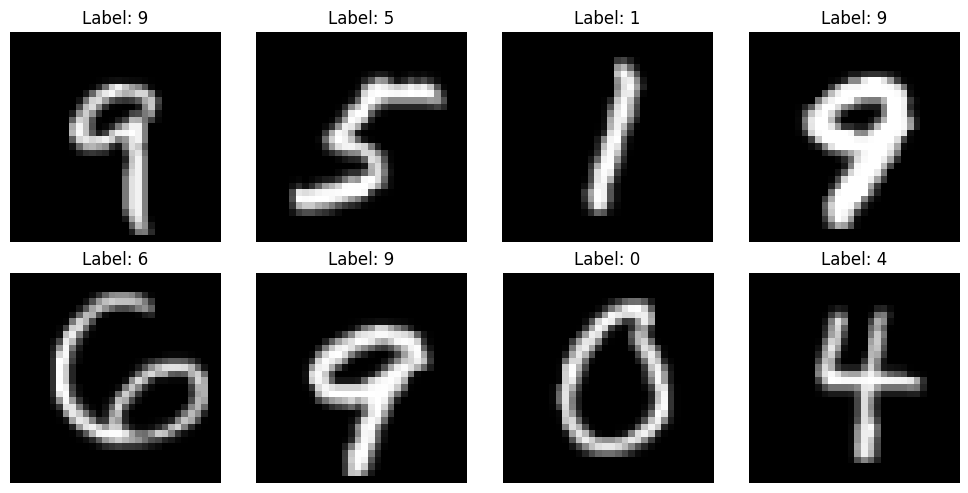

Image shape: torch.Size([1, 32, 32])
Labels: [9, 5, 1, 9, 6, 9, 0, 4]


In [5]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot some sample images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Image shape: {images[0].shape}")
print(f"Labels: {labels[:8].tolist()}")

## Model Initialization

In [6]:
# Initialize the diffusion U-Net model
model = deepinv.models.DiffUNet(in_channels=1, out_channels=1, pretrained=None).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = deepinv.loss.MSE()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model moved to: {next(model.parameters()).device}")

Total parameters: 93,555,841
Trainable parameters: 93,555,841
Model moved to: cuda:0


## Diffusion Schedule Setup

In [7]:
# Create noise schedule
betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

print(f"Beta schedule: {beta_start} to {beta_end}")
print(f"Betas shape: {betas.shape}")
print(f"Alpha cumulative product range: {alphas_cumprod.min():.6f} to {alphas_cumprod.max():.6f}")

Beta schedule: 0.0001 to 0.02
Betas shape: torch.Size([1000])
Alpha cumulative product range: 0.000040 to 0.999900


## Visualize Noise Schedule

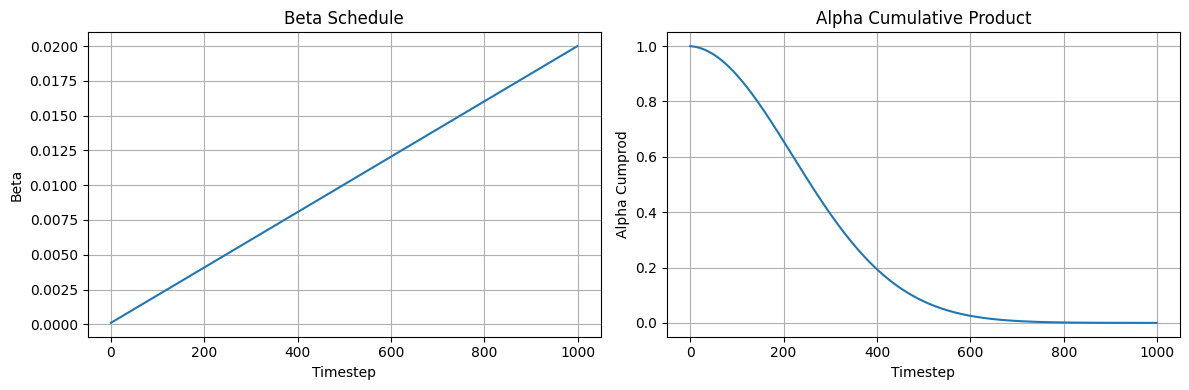

In [8]:
# Plot the noise schedule
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot betas
ax1.plot(betas.cpu().numpy())
ax1.set_title('Beta Schedule')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Beta')
ax1.grid(True)

# Plot alpha cumulative product
ax2.plot(alphas_cumprod.cpu().numpy())
ax2.set_title('Alpha Cumulative Product')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Alpha Cumprod')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Training Loop

In [9]:
# Training loop with progress tracking
losses = []
epoch_losses = []

print("Starting training...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        imgs = data.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        # Forward diffusion process
        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        # Training step
        optimizer.zero_grad()
        estimated_noise = model(noised_imgs, t, type_t="timestep")

        # Calculate MSE loss and ensure it's a scalar
        loss = torch.nn.functional.mse_loss(estimated_noise, noise)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1
        losses.append(loss.item())

    avg_epoch_loss = epoch_loss / num_batches
    epoch_losses.append(avg_epoch_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.6f}")

print("Training completed!")

Starting training...
Epoch [1/100], Average Loss: 0.024580
Epoch [10/100], Average Loss: 0.010112
Epoch [20/100], Average Loss: 0.009692
Epoch [30/100], Average Loss: 0.009421
Epoch [40/100], Average Loss: 0.009397
Epoch [50/100], Average Loss: 0.009285
Epoch [60/100], Average Loss: 0.009370
Epoch [70/100], Average Loss: 0.009269
Epoch [80/100], Average Loss: 0.009132
Epoch [90/100], Average Loss: 0.009222
Epoch [100/100], Average Loss: 0.009118
Training completed!


## Visualize Training Progress

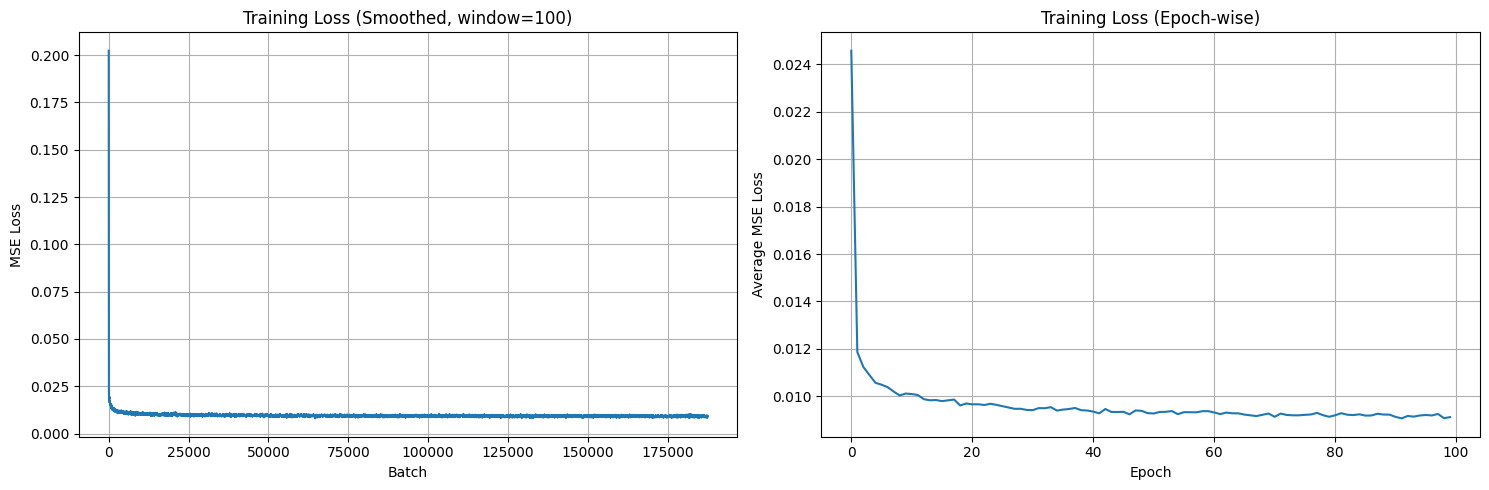

Final training loss: 0.009118
Best training loss: 0.009066 at epoch 92


In [10]:
# Plot training loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot batch losses (smoothed)
window_size = 100
if len(losses) > window_size:
    smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
    ax1.plot(smoothed_losses)
    ax1.set_title(f'Training Loss (Smoothed, window={window_size})')
else:
    ax1.plot(losses)
    ax1.set_title('Training Loss (Batch-wise)')
ax1.set_xlabel('Batch')
ax1.set_ylabel('MSE Loss')
ax1.grid(True)

# Plot epoch losses
ax2.plot(epoch_losses)
ax2.set_title('Training Loss (Epoch-wise)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average MSE Loss')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final training loss: {epoch_losses[-1]:.6f}")
print(f"Best training loss: {min(epoch_losses):.6f} at epoch {epoch_losses.index(min(epoch_losses))+1}")

## Save the Trained Model

In [11]:
# Save the trained model
model_path = "trained_diffusion_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

# Also save training metadata
training_info = {
    'epoch_losses': epoch_losses,
    'hyperparameters': {
        'batch_size': batch_size,
        'image_size': image_size,
        'lr': lr,
        'epochs': epochs,
        'beta_start': beta_start,
        'beta_end': beta_end,
        'timesteps': timesteps
    },
    'final_loss': epoch_losses[-1],
    'device': device
}

torch.save(training_info, "training_info.pth")
print("Training information saved to: training_info.pth")

Model saved to: trained_diffusion_model.pth
Training information saved to: training_info.pth


## Test Model Inference (Optional)

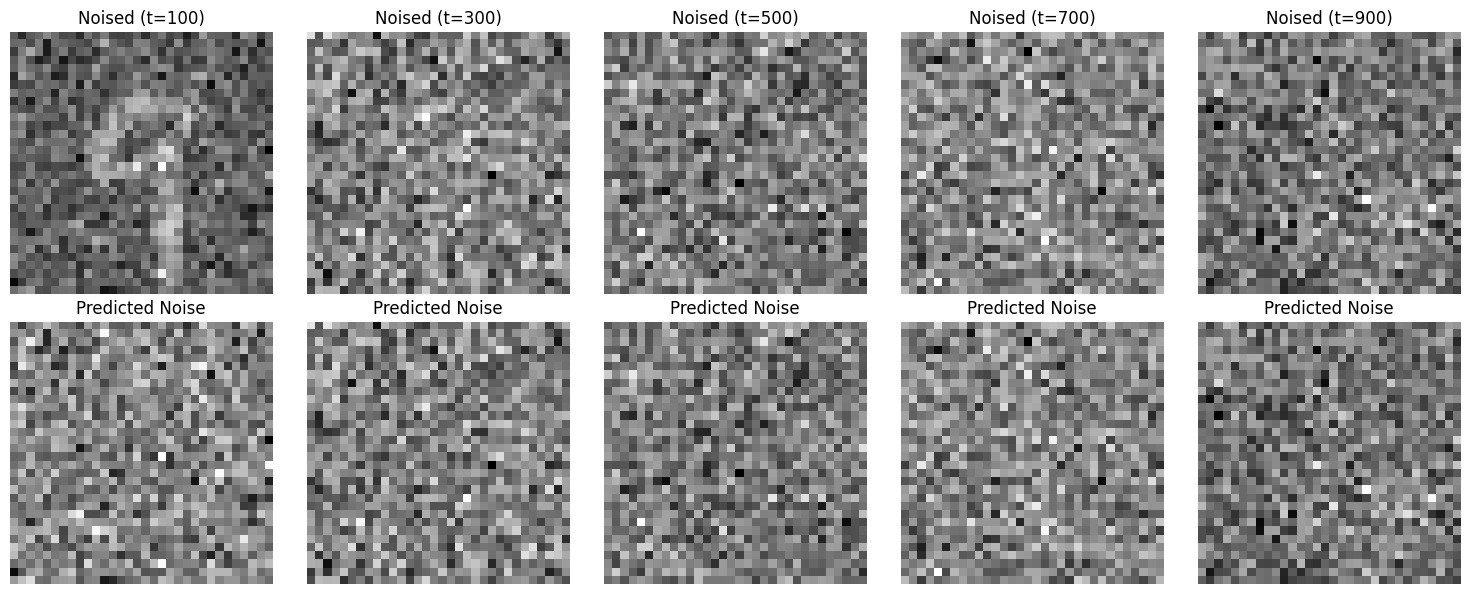

Model inference test completed!


In [16]:
# Test the model's noise prediction capability
model.eval()
with torch.no_grad():
    # Get a test image
    test_img = images[0:1].to(device)  # First image from the batch

    # Add noise at different timesteps
    test_timesteps = [100, 300, 500, 700, 900]

    fig, axes = plt.subplots(2, len(test_timesteps), figsize=(15, 6))

    for i, t_val in enumerate(test_timesteps):
        t = torch.tensor([t_val], device=device)
        noise = torch.randn_like(test_img)

        # Add noise
        noised_img = (
            sqrt_alphas_cumprod[t] * test_img +
            sqrt_one_minus_alphas_cumprod[t] * noise
        )

        # Predict noise
        predicted_noise = model(noised_img, t, type_t="timestep")

        # Show noised image
        axes[0, i].imshow(noised_img.cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f'Noised (t={t_val})')
        axes[0, i].axis('off')

        # Show predicted noise
        axes[1, i].imshow(predicted_noise.cpu().squeeze(), cmap='gray')
        axes[1, i].set_title(f'Predicted Noise')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

print("Model inference test completed!")

## Image Sampling from the Trained Model

Sampled Images:


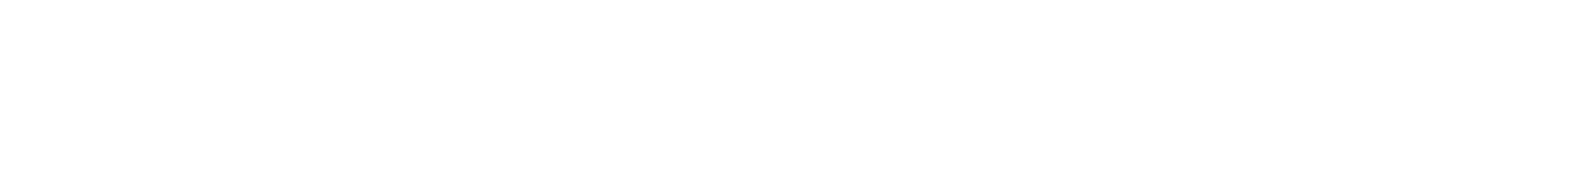

In [17]:
# Function to sample images from the diffusion model
@torch.no_grad()
def sample_images(model, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device, num_samples=8, image_size=32):
    model.eval()
    # Start with random noise
    img = torch.randn(num_samples, 1, image_size, image_size, device=device)

    # Denoise step by step
    for i in reversed(range(timesteps)):
        t = torch.full((num_samples,), i, device=device, dtype=torch.long)

        # Predict noise
        predicted_noise = model(img, t, type_t="timestep")

        # Calculate alpha and alpha cumulative product for the current timestep
        alpha = 1.0 - betas[i]
        alpha_cumprod = alphas_cumprod[i]

        # Calculate the denoised image
        img = (img - sqrt_one_minus_alphas_cumprod[i] * predicted_noise) / sqrt_alphas_cumprod[i]

        if i > 0:
            # Add noise for the next step (except for the last step)
            noise = torch.randn_like(img)
            sigma = betas[i].sqrt()
            img = img + sigma * noise

    # Clamp values to be within image range [0, 1] after normalization
    img = (img * 0.5) + 0.5 # Denormalize from [-1, 1] to [0, 1]
    img = torch.clamp(img, 0, 1)
    return img

# Sample and visualize images
sampled_images = sample_images(model, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)

print("Sampled Images:")
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes.flat):
    ax.imshow(sampled_images[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1) # Add cmap, vmin, vmax
    ax.axis('off')
plt.tight_layout()
plt.show()

## Visualize Denoising Process

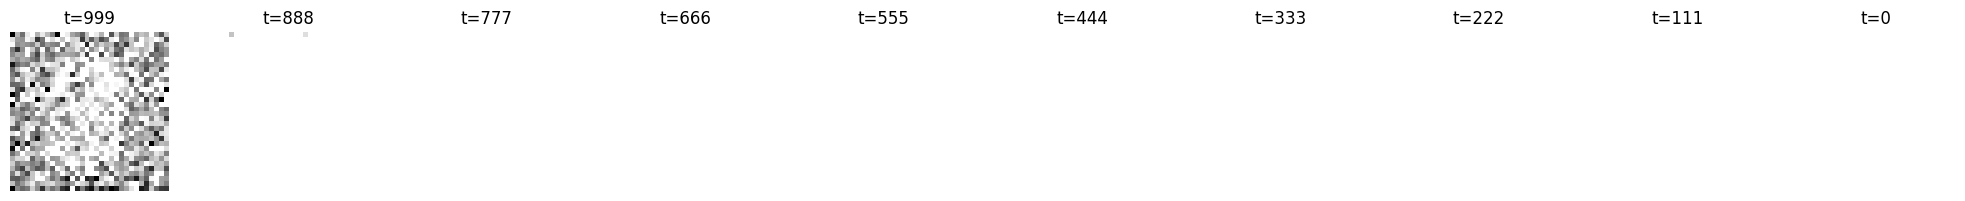

In [19]:
# Visualize the denoising process for a single sample
@torch.no_grad()
def visualize_denoising(model, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device, sample_idx=0, steps_to_show=10):
    model.eval()
    # Start with random noise for one sample
    img = torch.randn(1, 1, image_size, image_size, device=device)

    fig, axes = plt.subplots(1, steps_to_show, figsize=(steps_to_show * 2, 2))

    timesteps_to_show = torch.linspace(timesteps - 1, 0, steps_to_show, dtype=torch.long).to(device)

    for i, t_val in enumerate(timesteps_to_show):
        t = torch.full((1,), t_val, device=device, dtype=torch.long)

        # Predict noise
        predicted_noise = model(img, t, type_t="timestep")

        # Calculate alpha and alpha cumulative product for the current timestep
        alpha = 1.0 - betas[t]
        alpha_cumprod = alphas_cumprod[t]

        # Calculate the denoised image
        img = (img - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) / sqrt_alphas_cumprod[t]

        if t > 0:
            # Add noise for the next step
            noise = torch.randn_like(img)
            sigma = betas[t].sqrt()
            img = img + sigma * noise

        # Denormalize and clamp for display
        display_img = (img * 0.5) + 0.5
        display_img = torch.clamp(display_img, 0, 1)

        axes[i].imshow(display_img.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f't={t_val.item()}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the denoising process
visualize_denoising(model, timesteps, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)